### Model Selection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import sklearn as sklearn
import multiprocessing

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
plt.style.use("ggplot")
n_cores = multiprocessing.cpu_count()

In [3]:
X_train = pd.read_csv('./datasets/LosAngeles/cleaned/data_cleaned_train_X.csv')
y_train = pd.read_csv('./datasets/LosAngeles/cleaned/data_cleaned_train_y.csv')

X_val = pd.read_csv('./datasets/LosAngeles/cleaned/data_cleaned_val_X.csv')
y_val = pd.read_csv('./datasets/LosAngeles/cleaned/data_cleaned_val_y.csv')

X_test = pd.read_csv('./datasets/LosAngeles/cleaned/data_cleaned_test_X.csv')
y_test = pd.read_csv('./datasets/LosAngeles/cleaned/data_cleaned_test_y.csv')

In [4]:
y_train.dropna(how = 'any')
y_train.isnull().sum()

price_y    2
dtype: int64

In [5]:
y_train['price_y'][y_train['price_y'].isnull()]

9431    NaN
10590   NaN
Name: price_y, dtype: float64

In [6]:
y_val.isnull().sum()

price_y    0
dtype: int64

In [7]:
X_train = X_train.drop([9431,10590])
y_train = y_train.drop([9431,10590])

In [8]:
def get_ensemble_models():
    rf = RandomForestRegressor(
        n_estimators=51, min_samples_leaf=5, min_samples_split=3, random_state=42,
        n_jobs=int(0.8*n_cores))
    bag = BaggingRegressor(n_estimators=51, random_state=42, n_jobs=int(0.8*n_cores))
    extra = ExtraTreesRegressor(n_estimators=71, random_state=42, n_jobs=int(0.8*n_cores))
    grad = GradientBoostingRegressor(n_estimators=101, random_state=42)
    classifier_list = [rf, bag, extra, grad]
    classifier_name_list = ['Random Forests', 'Bagging',
                            'Extra Trees','Gradient Boost']
    return classifier_list, classifier_name_list


def print_evaluation_metrics(trained_model, trained_model_name, X_test, y_test):
    print('--------- For Model: ', trained_model_name, ' ---------(Validation Data)\n')
    predicted_values = trained_model.predict(X_test)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_test, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_test, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(y_test, predicted_values))
    print("R2: ", metrics.r2_score(y_test, predicted_values))
    plt.scatter(y_test, predicted_values, color='black')
    plt.title(trained_model_name)
    plt.xlabel('$y_{test}$')
    plt.ylabel('$y_{predicted}/y_{test}$')
    plt.savefig('%s.png' %trained_model_name, bbox_inches='tight')
    print("---------------------------------------\n")


def print_evaluation_metrics2(trained_model, trained_model_name, X_test, y_test):
    print('--------- For Model: ', trained_model_name, ' --------- (Train Data)\n')
    predicted_values = trained_model.predict(X_test)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_test, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_test, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(y_test, predicted_values))
    print("R2: ", metrics.r2_score(y_test, predicted_values))
    plt.scatter(y_test, predicted_values/y_test, color='black')
    plt_name = trained_model_name + " (Train Data)"
    plt.title(plt_name)
    plt.xlabel('$y_{test}$')
    plt.ylabel('$y_{predicted}/y_{test}$')
    plt.savefig('%s.png' %plt_name, bbox_inches='tight')
    print("---------------------------------------\n")


def LinearModel(X_train, y_train, X_val, y_val):
    regr = linear_model.LinearRegression(n_jobs=int(0.8*n_cores)).fit(X_train, y_train)
    y_pred = regr.predict(X_val)

    print('--------- For Model: LinearRegression --------- \n')
    print("Mean squared error: %.2f" % mean_squared_error(y_val, y_pred))
    print("R2: ", sklearn.metrics.r2_score(y_val, y_pred))


    plt.scatter(y_val, y_pred/y_val, color='black')
    plt.title('Linear Model Baseline')
    plt.xlabel('$y_{test}$')
    plt.ylabel('$y_{predicted}/y_{test}$')
    plt.savefig('Linear Model Baseline.png', bbox_inches='tight')    
    return


def TreebasedModel(X_train, y_train, X_val, y_val):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    y_train = np.squeeze(y_train)
    y_val = np.squeeze(y_val)

    classifier_list, classifier_name_list = get_ensemble_models()
    for classifier, classifier_name in zip(classifier_list, classifier_name_list):
        classifier.fit(X_train, y_train)
        print_evaluation_metrics2(classifier, classifier_name, X_train, y_train)
        print_evaluation_metrics(classifier, classifier_name, X_val, y_val)
    return

--------------------Linear Regression--------------------
--------- For Model: LinearRegression --------- 

Mean squared error: 45155.16
R2:  0.4438204419942532


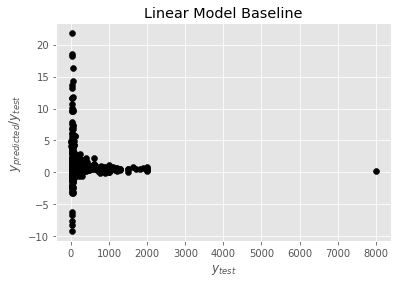

In [11]:
print("--------------------Linear Regression--------------------")
LinearModel(X_train, y_train, X_val, y_val)

--------------------Tree-based Model--------------------
--------- For Model:  Random Forests  --------- (Train Data)

Mean absolute error:  41.942622572811835
Median absolute error:  15.796740670463578
Mean squared error:  30602.635810068543
R2:  0.6321926540841434
---------------------------------------

--------- For Model:  Random Forests  ---------(Validation Data)

Mean absolute error:  56.82173622912149
Median absolute error:  23.513106725390465
Mean squared error:  31713.049852311662
R2:  0.609387960750374
---------------------------------------

--------- For Model:  Bagging  --------- (Train Data)

Mean absolute error:  23.2848023078105
Median absolute error:  8.509803921568633
Mean squared error:  8248.45868879802
R2:  0.900863320497863
---------------------------------------

--------- For Model:  Bagging  ---------(Validation Data)

Mean absolute error:  57.59995056235323
Median absolute error:  22.68627450980393
Mean squared error:  31852.490808497492
R2:  0.6076704559217

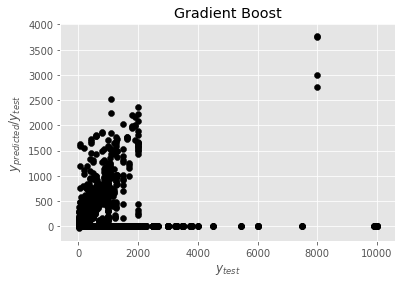

In [12]:
print("--------------------Tree-based Model--------------------")
TreebasedModel(X_train, y_train, X_val, y_val)

### Build Feature Importance

In [13]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
        n_estimators=51, min_samples_leaf=5, min_samples_split=3, random_state=42,
        n_jobs=int(0.8*n_cores))
rf.fit(X_train, y_train)

/Volumes/COSMOS/ProgramFiles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=51, n_jobs=12,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [14]:
len(rf.feature_importances_)

54

Text(0, 0.5, 'Normalized Gini Importance')

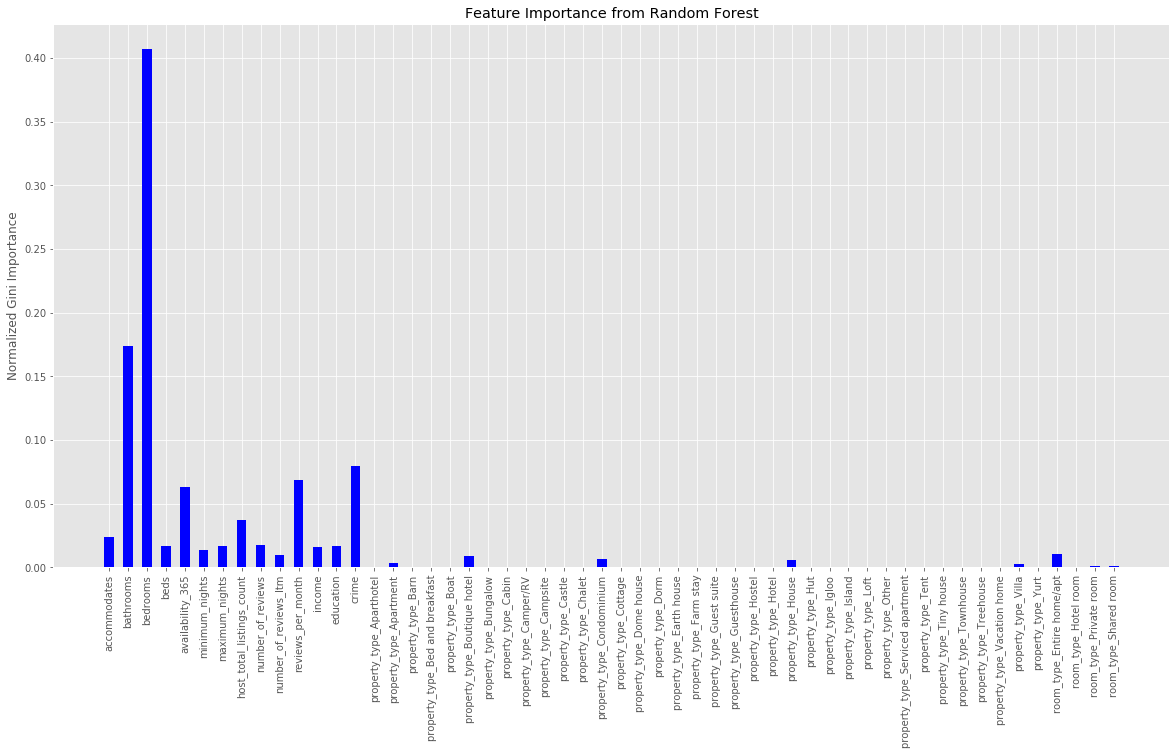

In [15]:
fig, ax = plt.subplots(figsize = (20,10))

ax.bar(np.arange(54), rf.feature_importances_, width = 0.5, color = 'b')
ax.set_xticks(np.arange(len(rf.feature_importances_)))
ax.set_xticklabels(X_train.columns.values, rotation = 90)
plt.title('Feature Importance from Random Forest')
ax.set_ylabel('Normalized Gini Importance')

In [16]:
rf_feature_importance = pd.DataFrame(np.array([X_train.columns,rf.feature_importances_]).T,\
                                  columns=['Features','Importance'])
rf_selected_fi = rf_feature_importance.sort_values(by='Importance',ascending=False)
rf_selected_fi.reset_index(drop = True)[:10]

,Features,Importance
0,bedrooms,0.406593
1,bathrooms,0.174065
2,crime,0.0798515
3,reviews_per_month,0.0686354
4,availability_365,0.0633299
5,host_total_listings_count,0.0373734
6,accommodates,0.0234608
7,number_of_reviews,0.017766
8,maximum_nights,0.0169014
9,education,0.0164859
